In [1]:
!pip install -q tensorflow-recommenders

In [2]:
import string # for string manipulation operations
import re # for regular expression operations n. 

import pandas as pd #for data manipulation and analysis
import numpy as np #for numerical computing
import seaborn as sns #for data visualization
import matplotlib.pyplot as plt #for data visualization
import tensorflow as tf #for building and training deep learning models
import tensorflow_recommenders as tfrs #as a high-level API for building recommendation models on top of TensorFlow
from collections import Counter #for counting occurrences of elements in a list or other iterable
from typing import Dict, Text #for declaring data types in a function or module
from ast import literal_eval #for evaluating strings as code
from datetime import datetime #for working with dates and times
from wordcloud import WordCloud #for generating word clouds from text
from sklearn.preprocessing import MinMaxScaler #for feature scaling
from sklearn.feature_extraction.text import TfidfVectorizer #for converting text into numerical features
from sklearn.metrics.pairwise import cosine_similarity #for measuring similarity between two non-zero vectors of an inner product space.
import random #To generate random numbers to select random movies for user to rate

import warnings
warnings.filterwarnings('ignore')

2023-01-30 13:48:15.264619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 13:48:15.448898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-01-30 13:48:15.448956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 13:48:16.567960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
#Import the required datasets
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')
#Merge all the datasets together
df = movies.merge(keywords, on='id').merge(credits, on='id')
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [4]:
#Fill in the missing values
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [5]:
#A function to extract the useful information from the columns
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

#Applying the functions to the columns    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

#Create new columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [6]:
#Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [7]:
#Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [8]:
#Changing the datatype of certain columns
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [9]:
#Here, I am choosing movies released after 2009 and which were originally shot in English
df = df[df['release_date'].dt.year>2009]
df = df[df['original_language']=='en']
df = df.reset_index()

In [10]:
#Total number of movies after filtering
df.shape

(8243, 22)

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

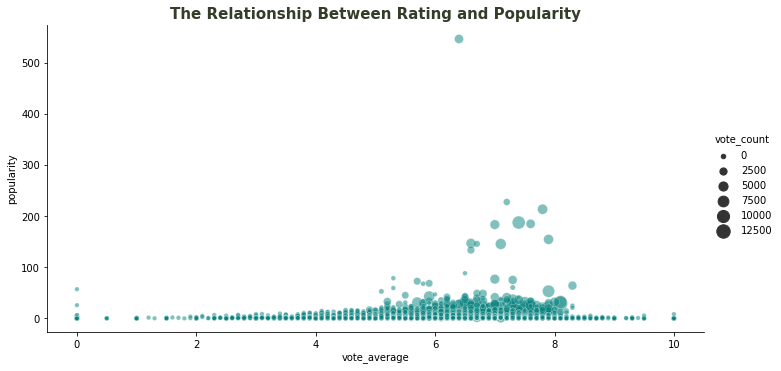

In [12]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Movies that either got rating 0 or 10 are basically caused by small number of voter. As the vote count increase, the rating is most likely around 5 to 8.5
* It's clear that popular movies will get more vote count as shown from above plot

<a id=4 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Deep Learning</b></h1>

Official documentation: https://www.tensorflow.org/recommenders

Tensorflow comes with a library called TensorFlow Recommenders (TFRS) for building a recommender system. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

This time, we use multi-objective approach that applies both implicit (movie watches) and explicit signals (ratings). In the end, we can predict what movies should the user watch along with the given rating corresponds to historical data

In [13]:
#Importing the dataset of the ratings
ratings_df = pd.read_csv('../input/the-movies-dataset/ratings.csv')

#Changing the datatype of the 'date' column
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

#Adding the columns from the merged dataset
ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)
ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,7,88744,1.5,2017-02-05 00:19:34,Die Frau mit den 5 Elefanten,"Documentary, Foreign","Documentary about Svetlana Geier, a Ukranian w..."
1,11,47518,3.0,2009-01-11 12:08:08,The Tortured,Horror,An upper-middle-class couple's life is destroy...
2,11,49530,3.5,2009-01-11 12:24:52,In Time,"Action, Thriller, Science Fiction",In the not-too-distant future the aging gene h...
3,11,50601,2.5,2009-01-11 13:02:10,5 Days of War,"War, Drama",An American journalist and his cameraman are c...
4,11,51540,4.0,2009-01-11 12:21:47,Horrible Bosses,"Comedy, Crime","For Nick, Kurt and Dale, the only thing that w..."


In [14]:
#Selecting the id and title column of the merged dataframe
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,79782,Wenecja
1,141210,The Sleepover
2,143750,The Farmer's Wife
3,84198,A Place at the Table
4,171982,Romance


In [15]:
#Selecting the UserId, title, and rating from the ratings dataframe
ratings_df = ratings_df[['userId', 'original_title', 'rating']]
ratings_df.head()

,userId,original_title,rating
0,7,Die Frau mit den 5 Elefanten,1.5
1,11,The Tortured,3.0
2,11,In Time,3.5
3,11,5 Days of War,2.5
4,11,Horrible Bosses,4.0


In [16]:
#Resetting the index of the movies dataframe
movies_df = movies_df.reset_index()
movies_df.head()

,index,movieId,original_title
0,0,79782,Wenecja
1,1,141210,The Sleepover
2,2,143750,The Farmer's Wife
3,3,84198,A Place at the Table
4,4,171982,Romance


In [17]:
#Resetting the index of the merged dataframe
df = df.reset_index()
df.head()
del df['level_0']

In [18]:
#Sorting by popularity to let the user rate the most popular ones
pdf = df.sort_values('popularity', ascending=False)
pdf = pdf.reset_index()
pdf.head()

,level_0,index,adult,budget,genres,id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,4194,28982,False,74000000.0,"Family, Animation, Adventure, Comedy",211672,en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,...,1.156731e+09,91.0,English,"Before Gru, they had a history of bad bosses",6.4,4729.0,"assistant, aftercreditsstinger, duringcreditss...","Christopher Meledandri, Kyle Balda, Ken Daurio...","Scarlet Overkill (voice), Herb Overkill (voice...","Sandra Bullock, Jon Hamm, Michael Keaton, Alli..."
1,7837,40726,False,34000000.0,"Action, Crime",339403,en,Baby Driver,After being coerced into working for a crime b...,228.032744,...,2.245113e+08,113.0,English,All you need is one killer track.,7.2,2083.0,"robbery, atlanta, music, crime boss, romance, ...","Edgar Wright, Edgar Wright, Tim Bevan, James B...","Baby, Deborah, Doc, Bats, Buddy, Darling, Jose...","Ansel Elgort, Lily James, Kevin Spacey, Jamie ..."
2,2752,23304,False,165000000.0,"Adventure, Family, Animation, Action, Comedy",177572,en,Big Hero 6,The special bond that develops between plus-si...,213.849907,...,6.521054e+08,102.0,English,From the creators of Wreck-it Ralph and Frozen,7.8,6289.0,"brother brother relationship, hero, talent, re...","John Lasseter, Robert Richardson, Mark Henley,...","Baymax (voice), Hiro Hamada (voice), Tadashi H...","Scott Adsit, Ryan Potter, Daniel Henney, T.J. ..."
3,3270,25206,False,58000000.0,"Action, Adventure, Comedy",293660,en,Deadpool,Deadpool tells the origin story of former Spec...,187.860492,...,7.831130e+08,108.0,English,Witness the beginning of a happy ending,7.4,11444.0,"anti hero, mercenary, marvel comic, superhero,...","Robert Alonzo, Tim Miller, Rhett Reese, Paul W...","Wade Wilson / Deadpool, Vanessa Carlysle / Cop...","Ryan Reynolds, Morena Baccarin, Ed Skrein, T.J..."
4,3272,25208,False,200000000.0,"Action, Adventure, Comedy, Science Fiction",283995,en,Guardians of the Galaxy Vol. 2,The Guardians must fight to keep their newfoun...,185.330992,...,8.634161e+08,137.0,English,Obviously.,7.6,4858.0,"sequel, superhero, based on comic, misfit, spa...","Lisa J. Levine, Jason C. Lewis, Lora Hirschber...","Peter Quill / Star-Lord, Gamora, Drax the Dest...","Chris Pratt, Zoe Saldana, Dave Bautista, Vin D..."


In [19]:
#Random number generation for the user to rate movies out of 5
user_id = 270897
m = 3
randomList = []
for i in range(10):
    r=random.randint(1,10)
    if r not in randomList:
        randomList.append(r)
        
print("Welcome")
name = input("Enter your name:")

for i in randomList:
    movie = pdf['original_title'][i]
    print(i)
    
    movie_row = pdf[pdf['original_title'] == movie]
    print()
    print(movie)
    print("Overview: ", pdf[pdf['original_title'] == movie]['overview'][i])
    print("Cast: ", pdf[pdf['original_title'] == movie]['actors'][i])
    user_r = input('Enter your rating out of 5 (Enter dk if you dont know the movie)')
    if(user_r=='dk'):
        continue;
    else:
        user_r = int(user_r)
        new_row = {'userId':270897, 'original_title':movie, 'rating':user_r}
        ratings_df = ratings_df.append(new_row, ignore_index=True)

Welcome


Enter your name: Prabhat


9

Captain America: Civil War
Overview:  Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarizes opinion amongst the Avengers, causing two factions to side with Iron Man or Captain America, which causes an epic battle between former allies.
Cast:  Chris Evans, Robert Downey Jr., Scarlett Johansson, Sebastian Stan, Anthony Mackie, Don Cheadle, Jeremy Renner, Chadwick Boseman, Paul Bettany, Elizabeth Olsen, Paul Rudd, Emily VanCamp, Tom Holland, Frank Grillo, William Hurt, Daniel Brühl, Martin Freeman, John Slattery, Marisa Tomei, Hope Davis, John Kani, Kerry Condon, Gene Farber, Florence Kasumba, Alfre Woodard, Jim Rash, Stan Lee, Joe Russo, Damion Poitier, Michael A. Cook, Laughton Parchment, Jackson Spidell, Yi Long, Heidi Moneymaker, Aaron Toney, Cale Schultz, Ann Russo, Cornell John, Sven Hönig, Joshua Peck, Brent McGee, Be Satrazemis, Blair Jasin, Oli Bigalke, Rafael Banasik, David de Vr

Enter your rating out of 5 (Enter dk if you dont know the movie) 5


8

War for the Planet of the Apes
Overview:  Caesar and his apes are forced into a deadly conflict with an army of humans led by a ruthless Colonel. After the apes suffer unimaginable losses, Caesar wrestles with his darker instincts and begins his own mythic quest to avenge his kind. As the journey finally brings them face to face, Caesar and the Colonel are pitted against each other in an epic battle that will determine the fate of both their species and the future of the planet.
Cast:  Andy Serkis, Woody Harrelson, Steve Zahn, Karin Konoval, Terry Notary, Ty Olsson, Michael Adamthwaite, Toby Kebbell, Judy Greer, Sara Canning, Max Lloyd-Jones, Devyn Dalton, Aleks Paunovic, Amiah Miller, Gabriel Chavarria, Alessandro Juliani, Chad Rook, Timothy Webber, Roger Cross, Mercedes de la Zerda


Enter your rating out of 5 (Enter dk if you dont know the movie) dk


7

The Hunger Games: Mockingjay - Part 1
Overview:  Katniss Everdeen reluctantly becomes the symbol of a mass rebellion against the autocratic Capitol.
Cast:  Jennifer Lawrence, Josh Hutcherson, Liam Hemsworth, Woody Harrelson, Donald Sutherland, Philip Seymour Hoffman, Julianne Moore, Willow Shields, Sam Claflin, Elizabeth Banks, Mahershala Ali, Jena Malone, Jeffrey Wright, Paula Malcomson, Stanley Tucci, Natalie Dormer, Evan Ross, Elden Henson, Wes Chatham, Sarita Choudhury, Stef Dawson, Patina Miller, Robert Knepper, Caitlin Fowler, Jada Taylor, Nicholas Pryor, Donna Biscoe, Michael Garza, Erika Bierman, Bill Bennett, Rus Blackwell, Stevie Ray Dallimore, Breann Couch, Jennifer Cocker, Marshall Choka, Jordan Woods-Robinson, Katie Sawhill, Jenique Bennett, Charles Kronmuller, Tyler Lee Allen, Jordanne Calvin, Jasmine Ahnie, Brayden Patterson, Emma Elle Roberts, A.J. Sexton, Sarah Turner Holland, Lauren Henneberg, Molly Evensen, William Frasca, Joe Crosson, Gregory Fears, Kirk Crenshaw

Enter your rating out of 5 (Enter dk if you dont know the movie) dk


2

Big Hero 6
Overview:  The special bond that develops between plus-sized inflatable robot Baymax, and prodigy Hiro Hamada, who team up with a group of friends to form a band of high-tech heroes.
Cast:  Scott Adsit, Ryan Potter, Daniel Henney, T.J. Miller, Jamie Chung, Damon Wayans Jr., Génesis Rodríguez, James Cromwell, Alan Tudyk, Maya Rudolph, Abraham Benrubi, Katie Lowes, Billy Bush, Daniel Gerson, Paul Briggs, Charlie Adler, Marcella Lentz-Pope, David Shaughnessy, Cam Clarke, Nicholas Guest, Terri Douglas, Tim Mertens, Yuri Lowenthal, Sundra Oakley, Brian R. Norris, Stan Lee, Shane Sweet, Frank Welker, David Cowgill, Kirk Baily, Charlotte Gulezian, Reed Buck, Roy Conli, Cooper Cowgill, Jackie Gonneau, Marlie Crisafulli, Bridget Hoffman, Kelly Hoover, Leah Latham, James Taku Leung, Yumi Mizui, Michael Powers, Lynwood Robinson, Josie Trinidad, Dan Howell, June Christopher


Enter your rating out of 5 (Enter dk if you dont know the movie) 4


4

Guardians of the Galaxy Vol. 2
Overview:  The Guardians must fight to keep their newfound family together as they unravel the mysteries of Peter Quill's true parentage.
Cast:  Chris Pratt, Zoe Saldana, Dave Bautista, Vin Diesel, Bradley Cooper, Michael Rooker, Karen Gillan, Pom Klementieff, Elizabeth Debicki, Chris Sullivan, Sean Gunn, Sylvester Stallone, Kurt Russell, Wyatt Oleff, Aaron Schwartz, Laura Haddock, Gregg Henry, Seth Green, Molly C. Quinn, Evan Jones, Jimmy Urine, Stephen Blackehart, Steve Agee, Joe Fria, Terence Rosemore, Tommy Flanagan, Richard Christy, Michael Rosenbaum, Ving Rhames, Michelle Yeoh, Rob Zombie, Jim Gunn Sr., Leota Gunn, Ben Browder, Rhoda Griffis, Kelly Richardson, Elizabeth Ludlow, Cheyanna Lavon Zubas, Hilty Bowen, Alexander Klein, Sierra Love, Milynn Sarley, David Hasselhoff, Hannah Gottesman, Luke Cook, Blondy Baruti, Mac Wells, Kendra Carelli, Damita Jane Howard, Brian Clackley, Tahseen Ghauri, Josh Tipis, Jason Williams, Stephen Vining, Stan Lee

Enter your rating out of 5 (Enter dk if you dont know the movie) 5


In [20]:
#Changing the datatype to string
ratings_df['userId'] = ratings_df['userId'].astype(str)

#Creating data for the model
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

2023-01-30 13:50:27.373645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-01-30 13:50:27.373707: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 13:50:27.373738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f62ce2b1b134): /proc/driver/nvidia/version does not exist
2023-01-30 13:50:27.374374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other 

In [21]:
#Displaying the total data
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 109488


In [22]:
#Displaying the total number of unique movies and users
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 8243
Unique users: 36333


In [23]:
#Creating the TensorFlow Model
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(labels=ratings,predictions=rating_predictions)
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [24]:
#Creating a model based on the above Class defintion
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 24s 567ms/step - root_mean_squared_error: 1.4763 - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.0822 - factorized_top_k/top_10_categorical_accuracy: 0.1648 - factorized_top_k/top_50_categorical_accuracy: 0.2955 - factorized_top_k/top_100_categorical_accuracy: 0.3231 - loss: 6866.0329 - regularization_loss: 0.0000e+00 - total_loss: 6866.0329
Epoch 2/3
35/35 [==============================] - 19s 547ms/step - root_mean_squared_error: 0.9954 - factorized_top_k/top_1_categorical_accuracy: 0.0076 - factorized_top_k/top_5_categorical_accuracy: 0.3129 - factorized_top_k/top_10_categorical_accuracy: 0.4566 - factorized_top_k/top_50_categorical_accuracy: 0.6447 - factorized_top_k/top_100_categorical_accuracy: 0.6863 - loss: 6589.4646 - regularization_loss: 0.0000e+00 - total_loss: 6589.4646
Epoch 3/3
35/35 [==============================] - 19s 554ms/step - root_mean_squared_error: 0.9704 

In [25]:
#Evaluating the model
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

9/9 [==============================] - 6s 454ms/step - root_mean_squared_error: 1.0186 - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.0506 - factorized_top_k/top_10_categorical_accuracy: 0.1020 - factorized_top_k/top_50_categorical_accuracy: 0.2989 - factorized_top_k/top_100_categorical_accuracy: 0.3773 - loss: 5729.0307 - regularization_loss: 0.0000e+00 - total_loss: 5729.0307

Retrieval top-100 accuracy: 0.377
Ranking RMSE: 1.019


In [26]:
#A function to recommend movies to the user
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, name))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

#Predict the rating a user will give for a movie        
def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".foxrmat(movie, predicted_rating.numpy()[0][0]))

In [27]:
#Displaying the movies and ratings of the user
ratings_df[ratings_df['userId']=='270897']

,userId,original_title,rating
109485,270897,Captain America: Civil War,5.0
109486,270897,Big Hero 6,4.0
109487,270897,Guardians of the Galaxy Vol. 2,5.0


In [28]:
#Predicting the movies for the users
predict_movie(270897, 5)

Top 5 recommendations for user Prabhat:

1. The Tortured
2. Stitches
3. Stolen Seas
4. The Lost Valentine
5. Cat Run


In [29]:
#Get meta data for recommendations
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

#Store the details of the recommendations in a new datafram
_, titles = index(tf.constant(['270897']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(df[['original_title', 'genres', 'overview', 'actors']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

In [30]:
#Displaying the details of the recommendations
for i in range(1,6):
    print("Details about your recommendations:")
    print("Number: ", i)
    print("Movie: ", pred_df['original_title'][i])
    print("Overview: ", pred_df['overview'][i])
    print("Genres: ", pred_df['genres'][i])
    print("Cast: ", pred_df['actors'][i])
    print()

Details about your recommendations:
Number:  1
Movie:  The Tortured
Overview:  An upper-middle-class couple's life is destroyed when their only child is kidnapped and killed. Obsessed with revenge, the couple seizes an opportunity to kidnap the killer.
Genres:  Horror
Cast:  Erika Christensen, Jesse Metcalfe, Bill Moseley, Chelah Horsdal, Fulvio Cecere, Aaron Pearl, Kayden Kessler, Sheila Shah, Samantha Gutstadt, Jakob Davies, Jessie Rusu, Viv Leacock, Yee Jee Tso, Stephen Park, Alfonso Quijada, Kurt Max Runte, Darryl Scheelar, Carl Mazzocone Sr., Bill Lippincott, Thomas Greenwood, Lynn Colliar, Marke Driesschen, Peter Abrams, Linda Curial, Paul Herbert, Stephen Miller, Nigel John Taylor, Donita Dyer, John Stewart, J. Larose, Zak Santiago

Details about your recommendations:
Number:  2
Movie:  Stitches
Overview:  The clumsy and unfunny clown Richard "Stitches" Grindle entertains at the 10th birthday party of little Tom, but the boy and his friends play a prank with Stitches, tying his 

In [31]:
print("Well that being said, I honestly hope these sound like movies you will watch")

Well that being said, I honestly hope these sound like movies you will watch
